# American Sign Language (ASL) Image Recognition

## Introduction

## Loading in dataset

In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile  
from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image                  
from tqdm import tqdm

# For compiling model
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

# For transfer learning
import scipy
import keras.applications.vgg16 as vgg16
import keras.applications.vgg19 as vgg19

# For confusion matrix calculation/visualization
import tensorflow as tf
import seaborn as sn
import pandas as pd

models_dir = 'saved_models'
data_dir = 'data'
bottleneck_feat_dir = 'bottleneck_features'

Using TensorFlow backend.


### Dividing data into training, validation, and testing sets

Now that preprocessing the images is completed (see `data_preprocessing.ipynb` notebook), the full dataset will be split into training, validation, and testing sets. The testing set will be all the images from one subject to mirror the "Spelling It Out" paper's method so the benchmark model can be compared. The rest of the images will be randomly split; 80% of images for training, 20% of the images for validation.

In [2]:
def load_dataset(path, n_categories=24):
    data = load_files(path)
    image_files = np.array(data['filenames'])
    # Hot encode categories to matrix
    image_targets = np_utils.to_categorical(np.array(data['target']), n_categories)
    return image_files, image_targets

def move_data_by_category(container_dir, regex_file_format='.*png'):
    '''Move data into a directory based on category'''
    # Still check if files are images
    file_list = [x for x in os.listdir(container_dir) if re.search(regex_file_format, x)]
    # Get numerical string (note that 1 digits are represented w/ 2 digits) 
    letters = {x.split('_')[0] for x in file_list}
    
    for letter in letters:
        # Only images that match letter
        images_with_letter = [filename for filename in file_list if filename.split('_')[0] == letter]
        # Add images to sub directory
        new_categ_path = os.path.join(container_dir, letter)
        if not os.path.exists(new_categ_path):
            os.makedirs(new_categ_path)
#         print('Created {new_categ_path} dir with {len(images_with_letter)} items')
        for img_filename in images_with_letter:
            path = os.path.join(container_dir, img_filename)
            new_path = os.path.join(new_categ_path, img_filename)            
            os.rename(path, new_path)
    # TODO: Check if any files were skipped (improperly named?)
        

def get_testing_data(data_dir, subject_num='4'):
    '''Get all data/images pertaining to one subject'''
    # Only search in directory for images with that subject
    file_list = [x for x in os.listdir(data_dir) if re.search('\d+_{}_\d*\.png'.format(subject_num), x)]
    
    # Make a new testing data directory if doesn't exist
    testing_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(testing_dir):
        os.makedirs(testing_dir)
        
    # Move images of particular subject into testing directory
    for image_filename in file_list:
        # file is **_n_****.png where n is an integer representing a subject
        _, subject, _ = image_filename.split('_')
        # Move file into testing directory
        path = os.path.join(data_dir, image_filename)
        new_path = os.path.join(testing_dir, image_filename)
        os.rename(path, new_path)
        
    # Move each image file's numerical str representing letters found in testing into own category directory
    move_data_by_category(testing_dir)
    
    return load_dataset(testing_dir)


def get_training_validation_data(data_dir, ratio=0.8):
    '''Randomly split data into training and validation sets'''
    # Only search in directory for images
    file_list = [x for x in os.listdir(data_dir) if re.search('.*png', x)]
    
    # Make a new training & validation data directory if doesn't exist
    train_dir = os.path.join(data_dir, 'train')
    valid_dir = os.path.join(data_dir, 'valid')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(valid_dir):
        os.makedirs(valid_dir)
        
    # Randomly split file list into training and vaidation sets
    np.random.shuffle(file_list)
    split_int = int(ratio * len(file_list))
    train_list = file_list[:split_int]
    valid_list = file_list[split_int:]
    
    # Move images of particular subject into testing directory
    for filenames, new_dir in [(train_list, train_dir), (valid_list, valid_dir)]:
        for image_filename in filenames:
            # Move file into testing directory
            path = os.path.join(data_dir, image_filename)
            new_path = os.path.join(new_dir, image_filename)
            os.rename(path, new_path)

        # Move each image file's numerical str representing letters found in testing into own category directory
        move_data_by_category(new_dir)
    
    return (load_dataset(train_dir), load_dataset(valid_dir))

In [3]:
# Manually set if the data is RGB
is_rgb = True

test_data, test_targets = get_testing_data(data_dir)
train, valid = get_training_validation_data(data_dir)
# Separated data and its targets
train_data, train_targets = train
valid_data, valid_targets = valid

### Display some of the images

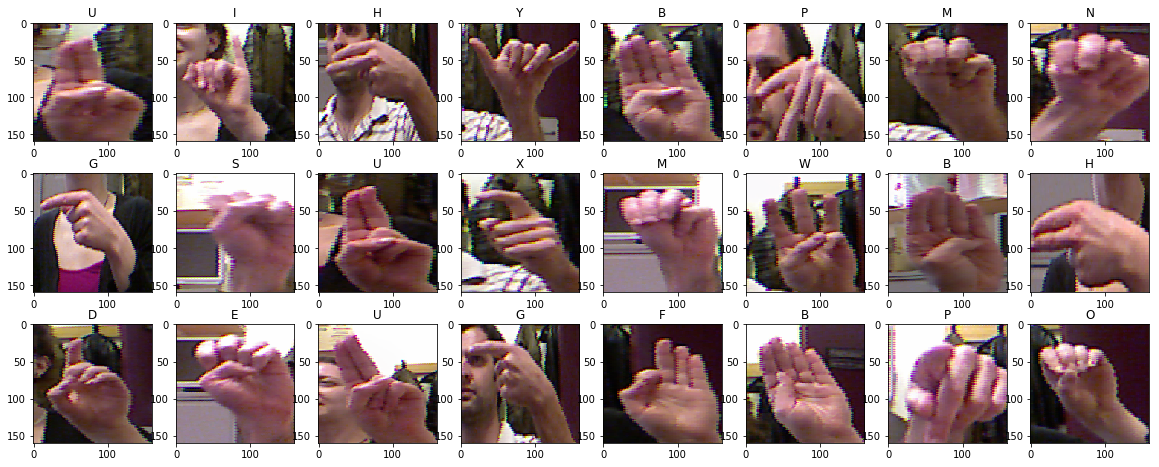

In [4]:
np.random.seed(8675309)
%matplotlib inline

# Display image previews below
plt.figure(figsize=(20,55))
columns = 8
n = 1

# Randomly choose images to display (with label)
for image_path in np.random.choice(train_data, 24, replace=False):
    img = Image.open(image_path)
    plt.subplot(20, columns, n)
    n+=1
    plt.imshow(img)
    letter = image_path.split('/')[-1][:2]
    letter = chr(int(letter)+65)
    plt.title(letter)

### Preparing the model

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (224, 224, 1)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 1) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
valid_tensors = paths_to_tensor(valid_data).astype('float32')
test_tensors = paths_to_tensor(test_data).astype('float32')

In [ ]:
# Prepare training data separately since this is usually large
train_tensors = paths_to_tensor(train_data).astype('float32')

## Basic CNN model from scratch

### Building basic model

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
#Convo 224, 224, 1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(224, 224, 1)))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
#
model.add(MaxPooling2D(pool_size=2))
#
model.add(GlobalAveragePooling2D())
#Dense; 24 for each handshape 
model.add(Dense(24, activation='softmax'))


model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Training basic model

In [ ]:
from keras.callbacks import ModelCheckpoint  

epochs = 16

# Create a saved models directory
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath=f'{models_dir}/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Evaluating basic model

In [ ]:
handshape_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(handshape_predictions)==np.argmax(test_targets, axis=1))/len(handshape_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

## Transfer Learning with VGG16

### Preparing the model

In [5]:
# Define image size to use for given model
n_pixels = 120
# Define a model name for recorcs
model_name ='rgbModel_{}px'.format(n_pixels) if is_rgb else 'model_{}px'.format(n_pixels)

In [6]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [9]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

  1%|          | 74/10599 [00:00<00:14, 729.27it/s]

Preparing to create valid tensors


100%|██████████| 10599/10599 [00:14<00:00, 720.17it/s]


valid tensors prepared


In [11]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

  1%|          | 70/12782 [00:00<00:18, 689.63it/s]

Preparing to create test tensors


100%|██████████| 12782/12782 [00:18<00:00, 692.76it/s]


test tensors prepared


In [7]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

  0%|          | 72/42393 [00:00<00:59, 713.67it/s]

Preparing to create train tensors


100%|██████████| 42393/42393 [01:00<00:00, 701.37it/s]


train tensors prepared


### Extract Bottleneck Features for Training Set

In [106]:
# Name & path of bottleneck features
feat_train_name = 'vgg16_{}_features_train'.format(model_name)
feat_train_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_train_name)

# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg16 model + remove final classification layers
model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists(feat_train_path):
    print('bottleneck features detected (train)')
    features = np.load(feat_train_path)['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg16_input_train = vgg16.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg16_input_train)
    features = np.squeeze(features)
    np.savez(feat_train_name, features=features)

print('bottleneck features saved (train)')

data loaded
model loaded
bottleneck features detected (train)
bottleneck features saved (train)


### Extract Bottleneck Features for Validation Set

In [107]:
# Name & path of bottleneck features
feat_valid_name = 'vgg16_{}_features_valid'.format(model_name)
feat_valid_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_valid_name)

# Obtain bottleneck features (valid)
if os.path.exists(feat_valid_path):
    print('bottleneck features detected (valid)')
    features_valid = np.load(feat_valid_path)['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg16_input_valid = vgg16.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg16_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez(feat_valid_name, features_test=features_valid)
print('bottleneck features saved (valid)')

bottleneck features detected (valid)
bottleneck features saved (valid)


### Extract Bottleneck Features for Test Set

In [12]:
# Name & path of bottleneck features
feat_test_name = 'vgg16_{}_features_test'.format(model_name)
feat_test_path = '{}/{}.npz'.format(bottleneck_feat_dir,feat_test_name)

# Obtain bottleneck features (test)
if os.path.exists(feat_test_path):
    print('bottleneck features detected (test)')
    features_test = np.load(feat_test_path)['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg16_input_test = vgg16.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg16_input_test)
    features_test = np.squeeze(features_test)
    np.savez(feat_test_name, features_test=features_test)
print('bottleneck features saved (test)')

bottleneck features file not detected (test)
calculating now ...
bottleneck features saved (test)


### Building model

In [183]:
# 3 CNN Layers
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))

model.add(Conv2D(filters=64, kernel_size=1))
model.add(Conv2D(filters=32, kernel_size=1))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 2, 2, 128)         262272    
_________________________________________________________________
dropout_119 (Dropout)        (None, 2, 2, 128)         0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 2, 2, 64)          8256      
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 2, 2, 32)          2080      
_________________________________________________________________
global_average_pooling2d_69  (None, 32)                0         
_________________________________________________________________
dropout_120 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 24)                792       
Total para

In [184]:
epochs = 75
batchsize = 4048
model_weights_path = '{}/vgg16_{}.best_batch{}_epoch{}.hdf5'.format(models_dir,model_name,batchsize,epochs)

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

Train on 42393 samples, validate on 10599 samples
Epoch 1/75
Epoch 00000: val_loss improved from inf to 10.06616, saving model to saved_models/vgg16_model_120px.best_batch4048_epoch75.hdf5
2s - loss: 13.0111 - acc: 0.1641 - val_loss: 10.0662 - val_acc: 0.3293
Epoch 2/75
Epoch 00001: val_loss improved from 10.06616 to 7.19498, saving model to saved_models/vgg16_model_120px.best_batch4048_epoch75.hdf5
1s - loss: 9.4990 - acc: 0.3692 - val_loss: 7.1950 - val_acc: 0.5116
Epoch 3/75
Epoch 00002: val_loss improved from 7.19498 to 5.07639, saving model to saved_models/vgg16_model_120px.best_batch4048_epoch75.hdf5
1s - loss: 7.4212 - acc: 0.4887 - val_loss: 5.0764 - val_acc: 0.6306
Epoch 4/75
Epoch 00003: val_loss improved from 5.07639 to 3.73870, saving model to saved_models/vgg16_model_120px.best_batch4048_epoch75.hdf5
1s - loss: 6.0433 - acc: 0.5709 - val_loss: 3.7387 - val_acc: 0.7237
Epoch 5/75
Epoch 00004: val_loss improved from 3.73870 to 3.43060, saving model to saved_models/vgg16_mode

Epoch 00048: val_loss did not improve
1s - loss: 0.5755 - acc: 0.9287 - val_loss: 0.3143 - val_acc: 0.9582
Epoch 50/75
Epoch 00049: val_loss did not improve
1s - loss: 0.5037 - acc: 0.9348 - val_loss: 0.4275 - val_acc: 0.9459
Epoch 51/75
Epoch 00050: val_loss improved from 0.26251 to 0.24056, saving model to saved_models/vgg16_model_120px.best_batch4048_epoch75.hdf5
1s - loss: 0.6456 - acc: 0.9189 - val_loss: 0.2406 - val_acc: 0.9686
Epoch 52/75
Epoch 00051: val_loss did not improve
1s - loss: 0.5095 - acc: 0.9340 - val_loss: 0.7215 - val_acc: 0.9175
Epoch 53/75
Epoch 00052: val_loss improved from 0.24056 to 0.23640, saving model to saved_models/vgg16_model_120px.best_batch4048_epoch75.hdf5
1s - loss: 0.5102 - acc: 0.9333 - val_loss: 0.2364 - val_acc: 0.9675
Epoch 54/75
Epoch 00053: val_loss did not improve
1s - loss: 0.5644 - acc: 0.9271 - val_loss: 1.1693 - val_acc: 0.8664
Epoch 55/75
Epoch 00054: val_loss improved from 0.23640 to 0.20509, saving model to saved_models/vgg16_model_120

### Evaluating the model

In [185]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 65.1932%


## Transfer Learning with VGG19

### Preparing the model

In [ ]:
# Define image size to use for given model
n_pixels = 160
# Define a model name for recorcs
model_name = 'model_{}px'.format(n_pixels)

In [ ]:
# Preprocessing data fro Keras (TensorFlow backend)
def path_to_tensor(img_path):
    # Loads image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(n_pixels, n_pixels), grayscale=False)
    # Convert PIL.Image.Image type to 3D tensor with shape (n, n, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, n, n, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 
# Pre-process the data for Keras
# Prepare training data separately since this is usually large

print('Preparing to create valid tensors')
valid_tensors = paths_to_tensor(valid_data).astype('float32')
print('valid tensors prepared')

In [ ]:
print('Preparing to create test tensors')
test_tensors = paths_to_tensor(test_data).astype('float32')
print('test tensors prepared')

In [ ]:
print('Preparing to create train tensors')
train_tensors = paths_to_tensor(train_data).astype('float32')
print('train tensors prepared')

### Extract Bottleneck Features for Training Set

In [ ]:
# Load the data
targets = np.squeeze(train_targets)
print('data loaded')

# Load vgg19 model + remove final classification layers
model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=(n_pixels, n_pixels, 3), classes=24)
print('model loaded')

# Obtain bottleneck features (train)
if os.path.exists('vgg19_features_train.npz'):
    print('bottleneck features detected (train)')
    features = np.load('vgg19_features_train.npz')['features']
else:
    print('bottleneck features file not detected (train)')
    
    print('calculating now ...')
    # Pre-process the train data
    big_x_train = np.array([scipy.misc.imresize(train_tensors[i], (n_pixels, n_pixels, 3)) 
                            for i in range(0, len(train_tensors))]).astype('float32')
    vgg19_input_train = vgg19.preprocess_input(big_x_train)
    print('train data preprocessed')
    
    # Extract, process, and save bottleneck features
    features = model.predict(vgg19_input_train)
    features = np.squeeze(features)
    np.savez('vgg19_features_train', features=features)

print('bottleneck features saved (train)')

### Extract Bottleneck Features for Validation Set

In [ ]:
# Obtain bottleneck features (valid)
if os.path.exists('vgg19_features_valid.npz'):
    print('bottleneck features detected (valid)')
    features_valid = np.load('vgg19_features_valid.npz')['features_test']
else:
    # Calculating for validation set
    print('bottleneck features file not detected (valid)')
    print('calculating now ...')
    # Pre-process the valid data
    big_x_valid = np.array([scipy.misc.imresize(valid_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(valid_tensors))]).astype('float32')

    vgg19_input_valid = vgg19.preprocess_input(big_x_valid)
    # Extract, process, and save bottleneck features (valid)
    features_valid = model.predict(vgg19_input_valid)
    features_valid = np.squeeze(features_valid)
    np.savez('vgg19_features_valid', features_test=features_valid)
print('bottleneck features saved (valid)')

### Extract Bottleneck Features for Test Set

In [ ]:
# Obtain bottleneck features (test)
if os.path.exists('vgg19_features_test.npz'):
    print('bottleneck features detected (test)')
    features_test = np.load('vgg19_features_test.npz')['features_test']
else:
    # Calculating for test set
    print('bottleneck features file not detected (test)')
    print('calculating now ...')
    # pre-process the test data
    big_x_test = np.array([scipy.misc.imresize(test_tensors[i], (n_pixels, n_pixels, 3)) 
                       for i in range(0, len(test_tensors))]).astype('float32')

    vgg19_input_test = vgg19.preprocess_input(big_x_test)
    # Extract, process, and save bottleneck features (test)
    features_test = model.predict(vgg19_input_test)
    features_test = np.squeeze(features_test)
    np.savez('vgg19_features_test', features_test=features_test)
print('bottleneck features saved (test)')

### Building model

In [ ]:
# Shallow NN
from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(filters=256, kernel_size=2, input_shape=features.shape[1:]))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])



In [ ]:
epochs = 256
batchsize = 512
model_weights_path = f'{models_dir}/vgg19_new_{model_name}.best_batch{batchsize}_epoch{epochs}.hdf5'

checkpointer = ModelCheckpoint(filepath=model_weights_path, 
                               verbose=1, save_best_only=True)

model.fit(features, targets, batch_size=batchsize, epochs=epochs,
          validation_data=(features_valid, valid_targets),
          callbacks=[checkpointer],
          verbose=2, shuffle=True)          

### Evaluating the model

In [ ]:
# Load the weights that yielded the best validation accuracy
model.load_weights(model_weights_path)

# Evaluate test accuracy
score = model.evaluate(features_test, test_targets, verbose=0)
accuracy = 100*score[1]

# Print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

## Confusion Matrix of Test Data

After performing tests, a confusion matrix can be used to evaluate the model and it's accuracy for each ASL handshape/letter. Below we use the weight's from the VGG16 model defined and used above to generate our confusion matrix.

In [21]:
# Compile model again (in case model hasn't been loaded)
# Note input shape manually entered; based on `features.shape[1:]`

model = Sequential()
model.add(Conv2D(filters=100, kernel_size=2, input_shape=(3,3,512)))
model.add(Dropout(0.4))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(24, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 2, 2, 100)         204900    
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 2, 100)         0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2424      
Total params: 207,324
Trainable params: 207,324
Non-trainable params: 0
_________________________________________________________________


In [186]:
# Load the weights of 
# model_weights_path = 'saved_models/vgg16_rgbModel_100px.best_batch500_epoch150.hdf5'
model.load_weights(model_weights_path)

test_predictions = model.predict_classes(features_test)

12320/12782 [===========================>..] - ETA: 0s

In [187]:
sess = tf.Session()
# Change one-hot encoding to just an integer representing letter
un_hot_encode_targets = np.argmax(test_targets, axis=1)

confusion_arr = sess.run(tf.confusion_matrix(un_hot_encode_targets, test_predictions, 24))
# Get percents to compare with research paper benchmark
confusion_arr_percents = confusion_arr/sum(confusion_arr)

In [190]:
# Note no 'J' & 'Z' were used
letters = "ABCDEFGHIKLMNOPQRSTUVWXY"

# Print out counts to see distribution of the number of letters tested against
for elem in ['{}: {}'.format(letter,count) for letter,count in zip(letters,sum(confusion_arr))]:
    print(elem)

A: 578
B: 567
C: 537
D: 335
E: 867
F: 534
G: 363
H: 671
I: 395
K: 380
L: 515
M: 740
N: 736
O: 436
P: 300
Q: 40
R: 440
S: 534
T: 876
U: 647
V: 674
W: 733
X: 476
Y: 408


In [188]:
# Save confusion matrix/array as CSVs for reference
np.savetxt('confusion_matrices/confusionMatrix.csv',confusion_arr)
np.savetxt('confusion_matrices/confusionMatrix_percent.csv',confusion_arr_percents)

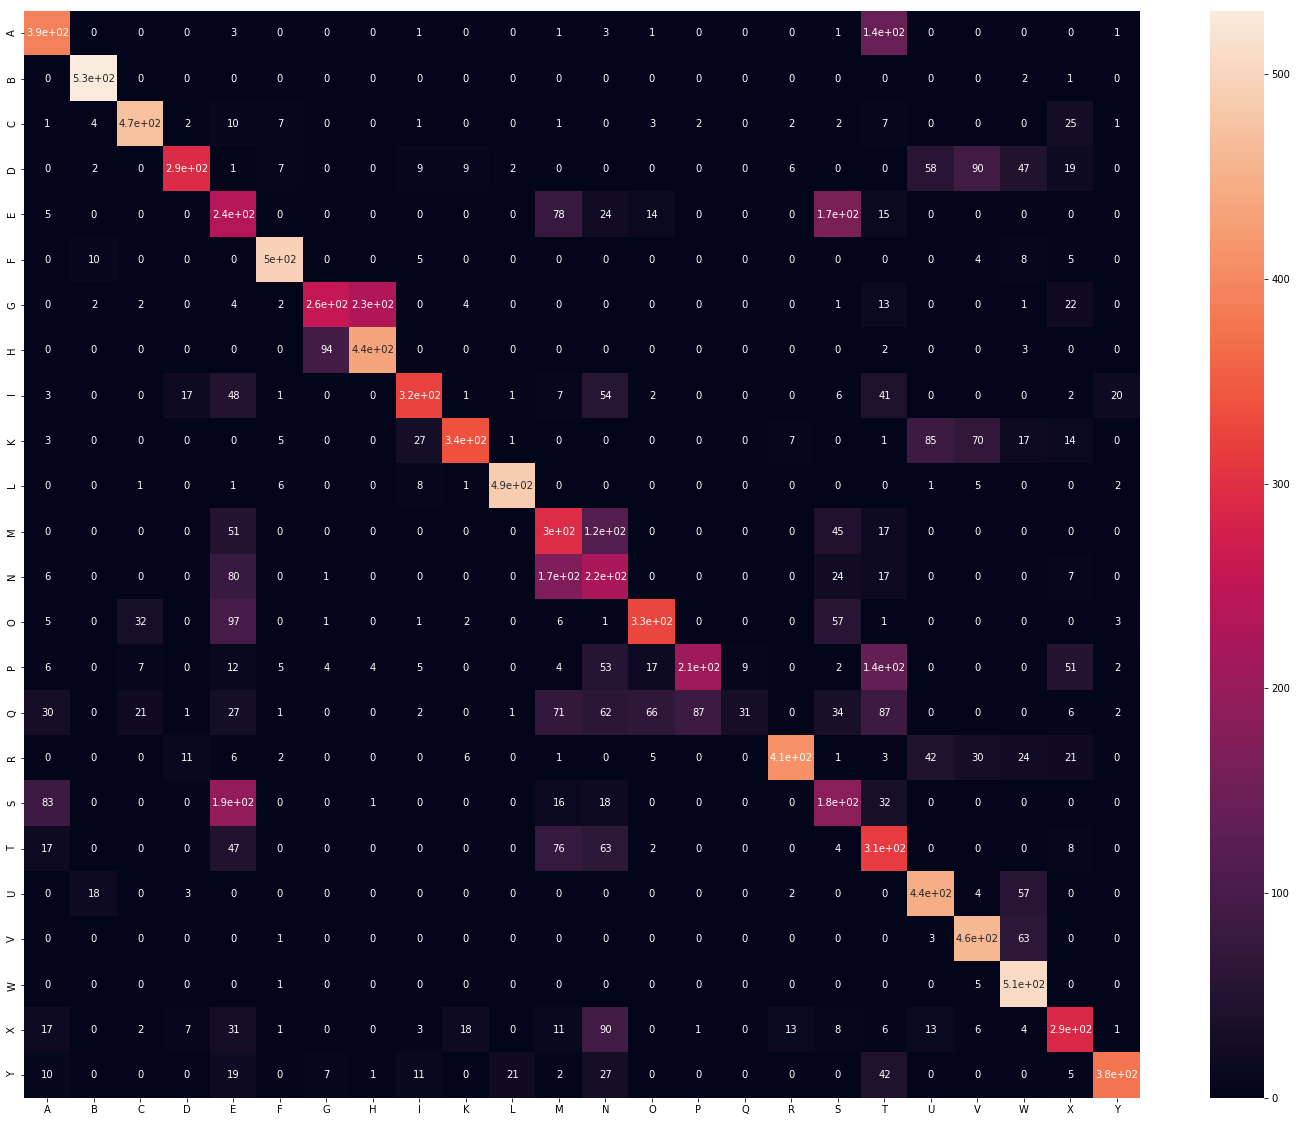

In [191]:
df_cm = pd.DataFrame(confusion_arr, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (25,20))
sn.heatmap(df_cm, annot=True)

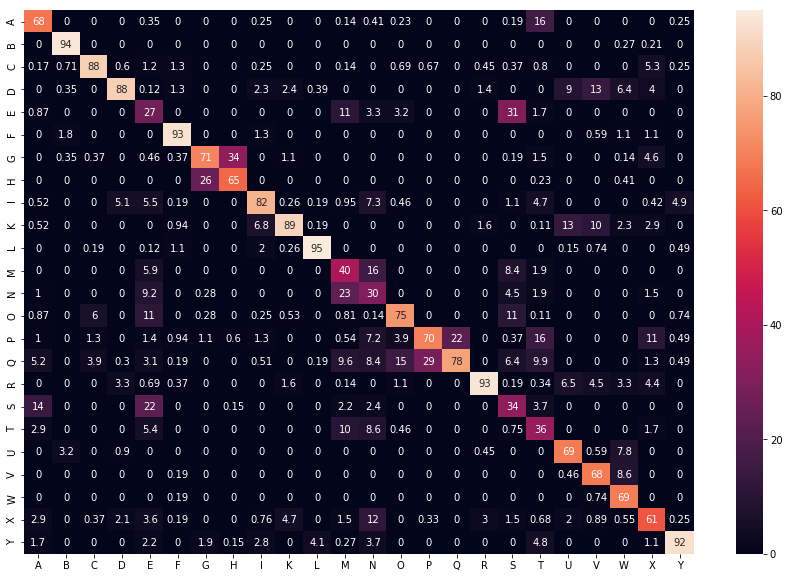

In [192]:
# Percentages for confusion matrix
# Multiplied by 100 to make it easier to read values
df_cm = pd.DataFrame(confusion_arr_percents*100, index = [i for i in letters],
                  columns = [i for i in letters])
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)